# Use LaCE to emulate P1D given a cosmological and IGM model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# our modules
from lace.cosmo import camb_cosmo
from lace.cosmo import fit_linP
from lace.emulator import nn_emulator
from lace.emulator import gp_emulator

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


### Load LaCE emulator

In [7]:
emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
training_set = 'Cabayol23'
if(training_set):
    emulator_label = "Cabayol23"
    emu_path = "NNmodels/Cabayol23/Cabayol23.pt"
    drop_sim_val = None
    pre_trained = True
    use_GP=False

In [9]:
if(pre_trained):
    emulator = nn_emulator.NNEmulator(
        training_set=training_set,
        emulator_label=emulator_label,
        emu_params=emu_params,
        model_path=emu_path,
        drop_sim=drop_sim_val,
        train=False,
    )    
else:
    if use_GP:
        emulator=gp_emulator.GPEmulator(training_set=training_set,emu_params=emu_params)
    else:
        # these might be sub-optimal settings for the Nyx emulator
        emulator=nn_emulator.NNEmulator(training_set=training_set,emu_params=emu_params)
    

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


In [10]:
# link to training data, in case it is useful
training_data=emulator.archive.get_training_data(emu_params=emu_params)
Na=len(training_data)
print(Na,'samples in training set')

9900 samples in training set


### Specify cosmological model

cosmo object will wrap a CAMB results object, and offer useful functionality.

In [11]:
cosmo=camb_cosmo.get_cosmology(H0=67,ns=0.96)

### Compute linear power parameters at the redshift of interest

In [12]:
z=3.0
test_params=fit_linP.get_linP_Mpc_zs(cosmo,zs=[z],kp_Mpc=emulator.archive.kp_Mpc)[0]
for key,value in test_params.items():
    print(key,'=',value)

Delta2_p = 0.3592783764295903
n_p = -2.3076121164022467
alpha_p = -0.21536809737918072
f_p = 0.9813418229699038


### Specify IGM parameters at the redshift

We need to choose a value of mean flux (mF), thermal broadening scale (sigT_Mpc), TDR slope gamma and filtering length (kF_Mpc).

We will choose values that are well sampled in the archive.

In [13]:
dz=0.1
zmask=[ (training_data[i]['z']<z+dz) & (training_data[i]['z']>z-dz) for i in range(Na)]

In [14]:
test_params

{'Delta2_p': 0.3592783764295903,
 'n_p': -2.3076121164022467,
 'alpha_p': -0.21536809737918072,
 'f_p': 0.9813418229699038}

In [15]:
for param in emu_params:
    if param in ['Delta2_p','n_p']: 
        continue
    test_params[param]=np.mean([ training_data[i][param] for i in range(Na) if zmask[i] ])
    print(param+' = {:.3f}'.format(test_params[param]))

mF = 0.659
sigT_Mpc = 0.128
gamma = 1.507
kF_Mpc = 10.746


### Ask emulator to predict P1D

In [16]:
# specify wavenumbers to emulate (in velocity units)
k_kms=np.logspace(np.log10(0.002),np.log10(0.02),num=20)
# use test cosmology to translate to comoving units
dkms_dMpc=camb_cosmo.dkms_dMpc(cosmo,z)
print('1 Mpc = {:.2f} km/s at z = {}'.format(dkms_dMpc,z))
k_Mpc=k_kms*dkms_dMpc

1 Mpc = 76.67 km/s at z = 3.0


In [17]:
# emulate P1D in comoving units
p1d_Mpc=emulator.emulate_p1d_Mpc(model=test_params,k_Mpc=k_Mpc)
# use test cosmology to translate back to velocity units
p1d_kms=p1d_Mpc*dkms_dMpc

Text(0, 0.5, 'k P(k)')

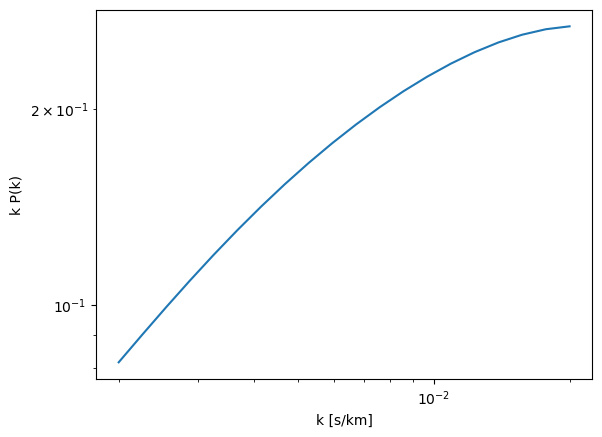

In [18]:
plt.loglog(k_kms,k_kms*p1d_kms)
plt.xlabel('k [s/km]')
plt.ylabel('k P(k)')